#### Ideal Quatum SVM Implementation - Lung Cancer 

In [1]:
# Check Qiskit, Qiskit Aer versions, Qiskit Machine Learning - Versions
import qiskit
import qiskit_aer
print(qiskit.__version__)
print("Aer:", qiskit_aer.__version__)

1.4.4
Aer: 0.17.2


In [2]:
# To ensure reproducibility of results
from qiskit_machine_learning.utils import algorithm_globals
algorithm_globals.random_seed = 12345

In [3]:
# --- Libnray Imports ---
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import chi2_contingency
from sklearn.model_selection import GridSearchCV, StratifiedKFold
# from imblearn.over_sampling import RandomOverSampler  # Added for optional balancing

In [4]:
# Qiskit Imports
# Definine quantum kernel
# Use the FidelityQuantumKernel class 

from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC

In [ ]:
# Load data first
lung_cancer_column_names = ['label'] + [f'attr_{i}' for i in range(1, 57)]
file_path_lung = r'C:\Users\User\Documents\MyProjects\FYP_ResearchProject\data\lung+cancer\lung-cancer.data'

# reads the data, treating "?" as missing values
df_lung = pd.read_csv(file_path_lung, header=None, names=lung_cancer_column_names, na_values=['?'])
print(f"Original shape of Lung Cancer data: {df_lung.shape}")

Original shape of Lung Cancer data: (32, 57)
Class distribution (binary):


KeyError: 'label_binary'

In [5]:
# Mode imputation for missing values
modes = df_lung.mode().iloc[0]
df_lung.fillna(modes, inplace=True)

# Then check if all Nan are gone
print(f"Total missing values after imputation: {df_lung.isnull().sum().sum()}\n")

Total missing values after imputation: 0



In [6]:
# Target Binarization
df_lung['label_binary'] = df_lung['label'].apply(lambda x: 0 if x == 1 else 1)

In [ ]:
# Check shape again
print("Class distribution (binary):")
print(df_lung['label_binary'].value_counts(normalize=True))

In [7]:
# Separate Features & Target and Split Data
X_lung = df_lung.drop(['label', 'label_binary'], axis=1)
y_lung_binary = df_lung['label_binary']

In [ ]:
X_train_lc, X_test_lc, y_train_lc, y_test_lc = train_test_split(
    X_lung, y_lung_binary, test_size=0.3, random_state=42, stratify=y_lung_binary
)

print(f"Train size: {X_train_lc.shape[0]}, Test size: {X_test_lc.shape[0]}")
print("Train class ratio:", y_train_lc.value_counts(normalize=True).to_dict())

In [9]:
# One-Hot Encoding
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_lc_encoded = pd.DataFrame(encoder.fit_transform(X_train_lc),
columns=encoder.get_feature_names_out())
X_test_lc_encoded = pd.DataFrame(encoder.transform(X_test_lc),
columns=encoder.get_feature_names_out())

In [10]:
# Feature Selection - Cramer's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    if min((kcorr-1), (rcorr-1)) == 0: return 0
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cramers_scores = {col: cramers_v(X_train_lc_encoded[col], y_train_lc) for col in X_train_lc_encoded.columns}
cramers_series = pd.Series(cramers_scores).sort_values(ascending=False)

N_FEATURES_TO_SELECT = 10 
top_features = cramers_series.head(N_FEATURES_TO_SELECT).index.tolist()

X_train_lc_final = X_train_lc_encoded[top_features]
X_test_lc_final = X_test_lc_encoded[top_features]

print("--- Data Preprocessing Complete ---")
print(f"Final training data shape: {X_train_lc_final.shape}")
print(f"Final testing data shape: {X_test_lc_final.shape}\n")


--- Data Preprocessing Complete ---
Final training data shape: (22, 10)
Final testing data shape: (10, 10)



##### Quantum Kernel Implementation

In [ ]:
# Quantum Kernel Setup - Ideal Setup
feature_dim = N_FEATURES_TO_SELECT
fm = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
sampler = Sampler(default_shots=256)

fidelity = ComputeUncompute(sampler=sampler)
qkernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=fm)

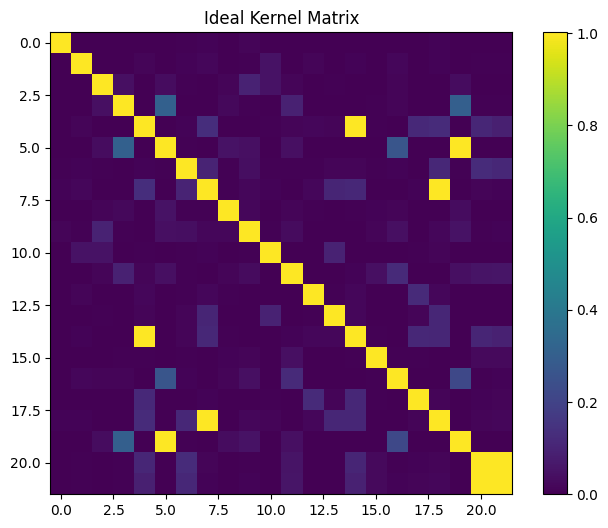

In [ ]:
# Plot the ideal kernel matrix
matrix_train_lc = qkernel.evaluate(x_vec=X_train_lc_final.to_numpy())
plt.figure(figsize=(8, 6))
plt.imshow(matrix_train_lc, cmap='viridis')
plt.title("Ideal Kernel Matrix")
plt.colorbar()
plt.show()

In [ ]:
# Ideal QSVC with tuned parameters
print("--- Training Ideal QSVC (Lung Cancer) ---")
start_time = time.time()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'class_weight': ['balanced']      # <<< keep this
}

# Use cross-validation suitable for small/imbalanced data
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# qsvc_ideal = QSVC(quantum_kernel=qkernel, C=1, class_weight='balanced')
# Grid search on QSVC
grid_search = GridSearchCV(
    QSVC(quantum_kernel=qkernel, class_weight='balanced'),  # Your QSVC setup
    param_grid,
    cv=cv,
    scoring='accuracy',  # Or 'f1_macro' for imbalanced classes
    n_jobs = -1
    verbose=1  # For progress output
)

# start_time = time.time()
# qsvc_ideal.fit(X_train_lc_final, y_train_lc)
# end_time = time.time()
# print(f"QSVC training finished in {end_time - start_time:.2f} seconds.")
# Fit (this will take time due to quantum kernel evaluations)

--- Training Ideal QSVC (Lung Cancer) ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters: {'C': 1}
QSVC training finished in 219.55 seconds.


In [ ]:
grid_search.fit(X_train_lc_final, y_train_lc)
qsvc_ideal = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
end_time = time.time()
print(f"QSVC training finished in {end_time - start_time:.2f} seconds.")

##### Model Evaluation

In [ ]:
##### Model Evaluation

y_train_pred = qsvc_ideal.predict(X_train_lc_final)
train_accuracy = accuracy_score(y_train_lc, y_train_pred)

y_test_pred = qsvc_ideal.predict(X_test_lc_final)
test_accuracy = accuracy_score(y_test_lc, y_test_pred)

generalization_gap = abs(train_accuracy - test_accuracy)

print(f"--- Ideal QSVC Evaluation (Lung Cancer) ---")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy:     {test_accuracy:.4f}")
print(f"Generalization Gap: {generalization_gap:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test_lc, y_test_pred, zero_division=0))

--- Ideal QSVC Evaluation (Lung Cancer) ---
Training Accuracy: 0.9091
Test Accuracy:     0.8000
Generalization Gap: 0.1091

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.78      1.00      0.88         7

    accuracy                           0.80        10
   macro avg       0.89      0.67      0.69        10
weighted avg       0.84      0.80      0.76        10

